<a href="https://colab.research.google.com/github/MrKozelberg/wavefunction_perceptron/blob/master/nn_solver_se.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the perceptron to the Laplace operator's eigen-problem

## Imports

In [1]:
print(__doc__)
import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn
import torch.nn.utils.parametrize as parametrize # to parameterize model

import scipy

Automatically created module for IPython interactive environment


## Detect available device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Definition of an activation function and its derivatives

In [3]:
def f0(x):
  return torch.log(1+torch.exp(x))

def f1(x):
  return 1/(1+torch.exp(-x))

def f2(x):
  return torch.exp(-x)/(1+torch.exp(-x))**2

## Amplitude and its derivatives

In [4]:
class Amplitude(nn.Module):
  def __init__(self, L=1.0):
    super().__init__()
    self.L = L

  def forward(self, input):
    p = torch.ones(input.shape[0]).to(device)
    for i in range(input.shape[1]):
      p *= (input[:,i] - self.L/2)**2-self.L**2/4
    return p.reshape((len(input),1))

class Amplitude_gradient(nn.Module):
  def __init__(self, L=1.0):
    super().__init__()
    self.L = L
    self.A = Amplitude(L)

  def forward(self, input):
    p = torch.ones(input.shape).to(device)
    for i in range(input.shape[1]):
      p[:, i] = self.A(input)[:,0] * 2 * (input[:,i] \
                                - self.L/2) / ((input[:,i] \
                                                - self.L/2)**2-self.L**2/4)
    return p

class Amplitude_laplacian(nn.Module):
  def __init__(self, L=1.0):
    super().__init__()
    self.L = L
    self.A = Amplitude(L)

  def forward(self, input):
    return (2 * self.A(input)[:,0] * torch.sum(((input \
                                      - self.L/2)**2 \
                                     - self.L**2/4)**(-1),
                                     axis=1)).reshape((len(input),1))

## Class for the perceptron-wavefunction 

In [5]:
class Perceptron(nn.Module):

  def __init__(self, N, L, layersizes):
    super(Perceptron, self).__init__()
    self.N = N  # size of the input vector
    self.V = L**N  # volume of the space
    self.layersizes = layersizes  # sizes of hidden layers
    self.l = len(self.layersizes)  # number of hidden layers
    # Amplitude and its derivatives
    self.A = Amplitude(L)
    self.A_gradient = Amplitude_gradient(L)
    self.A_laplacian = Amplitude_laplacian(L)
    # layers        
    self.linear_tanh_stack = nn.Sequential()
    for i in range(self.l + 1):
      if i == 0:
        self.linear_tanh_stack.append(nn.Linear(N, self.layersizes[i]))
      elif i == self.l:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1], 1))
      else:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1],
                                                self.layersizes[i]))
      self.linear_tanh_stack.append(nn.Tanh())
    self.h = [None] * (self.l + 1)  # outputs of the layers

  def forward(self, x):
    for i in range(self.l + 1):
      if i == 0:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](x))
      else:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](self.h[i-1]))
    # print((self.V * torch.mean((self.A(x) * self.h[-1])**2)))
    return self.A(x) * self.h[-1] #/ torch.sqrt(self.V * torch.mean((self.A(x) * self.h[-1])**2))

  def gradient(self, x):
    """
    finds the gradient of the wave function at a given point x
    """
    _ = self.forward(x)  # computes outputs of the layers
    self.gradient_array = torch.zeros(x.shape).to(device)
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device) #
      dh_dx[t] = 1 # 
      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias
        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)   
      self.gradient_array[:,t] = dh_dx.reshape(-1)
    return (self.A_gradient(x) * self.h[-1] \
            + self.A(x) \
            * self.gradient_array)# / torch.sqrt(self.V * torch.mean((self.A(x) * self.h[-1])**2))
  
  def laplacian(self, x):
    """
    finds the Laplacian of the wave function at a given point x
    """
    a = self.forward(x)  # computes outputs of the layers
    b = self.gradient(x)
    laplacian = 0.0
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device)
      dh_dx[t] = 1
      d2h_dx2 = torch.zeros(self.N).to(device)
      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias
        # firstly, the new value of the second derivative computes as it is 
        # used the previous value of the first derivative
        if i == 0:
          d2h_dx2 = f2(x @ w.T + b) * (dh_dx @ w.T)**2
        else:
          d2h_dx2 = f2(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)**2\
                    + f1(self.h[i-1] @ w.T + b) * (d2h_dx2 @ w.T)
        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T) 
      laplacian += d2h_dx2
    return (self.A_laplacian(x) * self.h[-1] \
            + 2 * torch.sum(self.A_gradient(x) * self.gradient_array,
                            axis=1).reshape((len(x),1)) \
            + self.A(x) \
            * laplacian) #/ torch.sqrt(self.V * torch.mean((self.A(x) * self.h[-1])**2))

In [6]:
def train_loop_laplacian_state0(N, n_iter, n_sample, model, L=1.0):
  # Optimisation things
  optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
  loss_fn = nn.L1Loss()
  n_x = n_sample * np.ones(n_iter, dtype=int)  # np.logspace(1, np.log10(n_iter)-1, n_iter, dtype=int)
  # arrays to output
  energy = np.zeros(n_iter, dtype=float)
  loss_val = np.zeros(n_iter, dtype=float)
  # loop
  print("Iteration number   E   abs_err_E   Loss")
  for iter in range(n_iter):
    x = torch.rand((n_x[iter], N)).to(device) * L
    # Energy
    energy[iter] = torch.mean(-model(x)*model.laplacian(x))/torch.mean(model(x)**2)
    # Compute loss
    loss = loss_fn(torch.mean((-model.laplacian(x) \
                               - torch.mean(-model(x)*model.laplacian(x))/torch.mean(model(x)**2)* model(x))**2)\
                   + torch.mean((model(x) - model(L-x))**2)\
                   + 1e-5*abs(torch.mean(model(x)**2) - 1),
                   torch.zeros(torch.Size([])).to(device))
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val[iter] = loss.item()
    if np.isnan(loss.item()):
      print(f'[{iter+1:>5d} / {n_iter:>5d}] LOSS FUNCTION IS NAN')
      return energy, loss_val
    if (iter+1) % 1000 == 0:
      print(f"{iter+1:>5d} {energy[iter-999:iter].mean():>0.2E} {energy[iter-999:iter].mean()-np.pi**2:>0.2E} {loss_val[iter]:>0.2E}")
    scheduler.step()
  return energy, loss_val

# 1D

In [7]:
N = 1  # size of the input vector
perceptron0 = Perceptron(N, 1, [100,100]).to(device)

In [9]:
e0, l0 = train_loop_laplacian_state0(N, 15000, 100, perceptron0)

Iteration number   E   abs_err_E   Loss
 1000 8.95E+00 -9.21E-01 1.01E-05
 2000 9.49E+00 -3.76E-01 1.05E-05
 3000 9.42E+00 -4.52E-01 1.01E-05
 4000 9.23E+00 -6.39E-01 1.01E-05
 5000 9.57E+00 -3.02E-01 1.00E-05
 6000 9.35E+00 -5.18E-01 1.25E-05
 7000 9.72E+00 -1.51E-01 1.00E-05
 8000 9.36E+00 -5.06E-01 1.00E-05
 9000 9.64E+00 -2.29E-01 1.00E-05
10000 9.30E+00 -5.66E-01 1.04E-05
11000 9.52E+00 -3.46E-01 1.00E-05
12000 9.34E+00 -5.27E-01 1.00E-05
13000 9.61E+00 -2.58E-01 1.00E-05
14000 9.43E+00 -4.44E-01 1.00E-05
15000 9.56E+00 -3.06E-01 1.00E-05


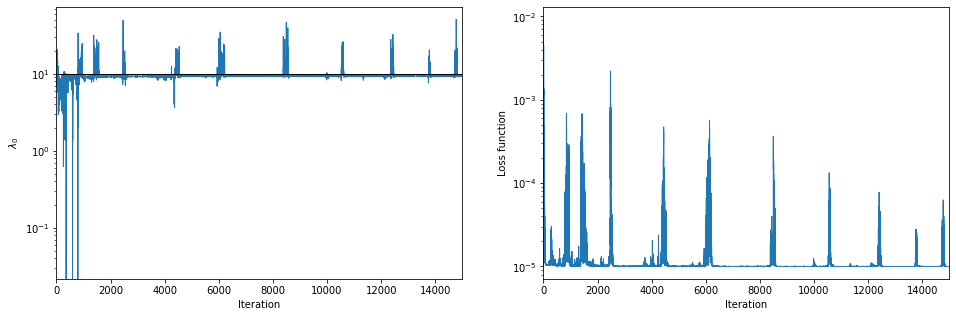

In [10]:
fig, (ax_e, ax_l) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

ax_e.plot(np.arange(len(e0)), e0, linewidth=1)
ax_e.axhline(y=np.pi**2, linestyle='-', color='black', linewidth=1)

ax_e.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_e.set_xlabel('Iteration')
ax_e.set_ylabel(r'$\lambda_0$')

ax_e.set_xlim(np.arange(len(e0))[[0,-1]])
# ax_e.set_ylim(9,10)

ax_l.plot(np.arange(len(l0)), l0, linewidth=1)

ax_l.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_l.set_xlabel('Iteration')
ax_l.set_ylabel(r'Loss function')

ax_l.set_xlim(np.arange(len(e0))[[0,-1]])
# ax_l.set_ylim(9.6,10)

fig.savefig('lambda0_loss0.png', dpi=300, bbox_inches='tight')

In [14]:
def train_loop_laplacian_state1(N, n_iter, n_sample, model0, model1, L=1.0):
  # Optimisation things
  optimizer = torch.optim.Adam(params = model1.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
  loss_fn = nn.L1Loss()
  n_x = n_sample * np.ones(n_iter, dtype=int)  # np.logspace(1, np.log10(n_iter)-1, n_iter, dtype=int)
  # arrays to output
  energy = np.zeros(n_iter, dtype=float)
  loss_val = np.zeros(n_iter, dtype=float)
  # loop
  print("Iteration number   E   abs_err_E   Loss")
  for iter in range(n_iter):
    x = torch.rand((n_x[iter], N)).to(device) * L
    model = model1(x) - model0(x) * torch.mean(model0(x) * model1(x))/torch.mean((model0(x))**2)
    # Energy
    energy[iter] = torch.mean(-model*model1.laplacian(x))/torch.mean(model**2)
    # Compute loss
    loss = loss_fn(torch.mean((-model1.laplacian(x) \
                               - torch.mean(-model*model1.laplacian(x))/torch.mean(model**2)* model)**2)\
                   + torch.mean((model1(x) + model1(L-x))**2)\
                   + 1e-5*abs(torch.mean(model**2) - 1),
                   torch.zeros(torch.Size([])).to(device))
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val[iter] = loss.item()
    if np.isnan(loss.item()):
      print(f'[{iter+1:>5d} / {n_iter:>5d}] LOSS FUNCTION IS NAN')
      return energy, loss_val
    if (iter+1) % 1000 == 0:
      print(f"{iter+1:>5d} {energy[iter-999:iter].mean():>0.2E} {energy[iter-999:iter].mean()-4*np.pi**2:>0.2E} {loss_val[iter]:>0.2E}")
    scheduler.step()
  return energy, loss_val

In [25]:
N = 1  # size of the input vector
perceptron1 = Perceptron(N, 1, [100,100]).to(device)

e1, l1 = train_loop_laplacian_state1(N, 15000, 200, perceptron0, perceptron1)

Iteration number   E   abs_err_E   Loss
 1000 1.10E+01 -2.85E+01 1.01E-05
 2000 7.35E+00 -3.21E+01 1.02E-05
 3000 9.56E+00 -2.99E+01 1.03E-05
 4000 5.23E+00 -3.42E+01 6.47E-05
 5000 2.77E+00 -3.67E+01 1.60E-05
 6000 1.73E+01 -2.22E+01 2.17E-05
 7000 1.46E+01 -2.49E+01 1.00E-05
 8000 1.73E+01 -2.22E+01 3.37E-05
 9000 1.72E+01 -2.23E+01 1.00E-05
10000 1.15E+01 -2.80E+01 1.00E-05
11000 5.65E+00 -3.38E+01 1.00E-05
12000 1.41E+01 -2.54E+01 1.37E-05
13000 1.04E+01 -2.91E+01 1.00E-05
14000 1.04E+01 -2.91E+01 1.03E-05
15000 8.69E+00 -3.08E+01 1.37E-05


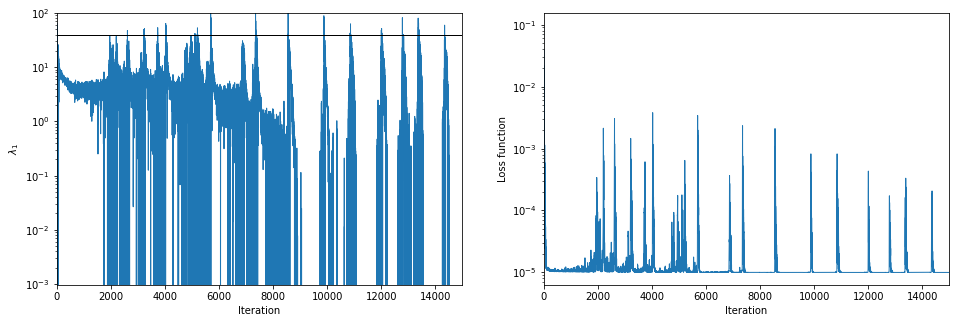

In [24]:
fig, (ax_e, ax_l) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

ax_e.plot(np.arange(len(e1)), e1, linewidth=1)
ax_e.axhline(y=4*np.pi**2, linestyle='-', color='black', linewidth=1)

ax_e.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_e.set_xlabel('Iteration')
ax_e.set_ylabel(r'$\lambda_1$')

ax_e.set_xlim(np.arange(len(e0))[[0,-1]])
ax_e.set_ylim(None,1e2)

ax_l.plot(np.arange(len(l1)), l1, linewidth=1)

ax_l.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_l.set_xlabel('Iteration')
ax_l.set_ylabel(r'Loss function')

ax_l.set_xlim(np.arange(len(e1))[[0,-1]])
# ax_l.set_ylim(9.6,10)

fig.savefig('lambda1_loss1.png', dpi=300, bbox_inches='tight')

In [25]:
(e0.mean() - np.pi**2) / np.pi**2

0.015468673219951544

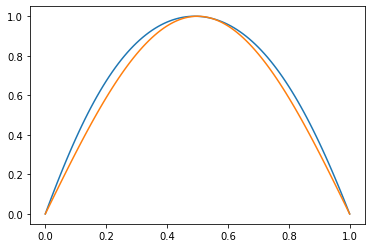

In [120]:
y = perceptron0(torch.linspace(0,1,101).reshape((101,1)).to(device)).cpu().detach().numpy()
x = np.linspace(0,1,101)
plt.plot(x,abs(y)/abs(y).max())
plt.plot(x,np.sin(x*np.pi)/np.sin(x*np.pi).max())

In [148]:
N = 2  # size of the input vector
perceptron0_2d = Perceptron(N, 1, [100,100]).to(device)

In [149]:
e0_2d, l0_2d = train_loop_laplacian_state0(N, 15000, 100, perceptron0_2d)

Iteration number   E   abs_err_E   Loss
 1000 1.66E+01 6.72E+00 1.01E-05
 2000 1.97E+01 9.85E+00 1.00E-05
 3000 2.04E+01 1.05E+01 1.21E-05
 4000 2.06E+01 1.07E+01 1.00E-05
 5000 2.09E+01 1.11E+01 1.01E-05
 6000 2.13E+01 1.14E+01 1.00E-05
 7000 2.13E+01 1.15E+01 1.00E-05
 8000 2.12E+01 1.14E+01 1.00E-05
 9000 2.13E+01 1.14E+01 1.00E-05
10000 2.06E+01 1.08E+01 1.00E-05
11000 2.04E+01 1.05E+01 1.00E-05
12000 2.04E+01 1.05E+01 1.00E-05
13000 2.10E+01 1.12E+01 1.00E-05
14000 2.16E+01 1.17E+01 1.00E-05
15000 2.15E+01 1.17E+01 1.00E-05


NameError: ignored

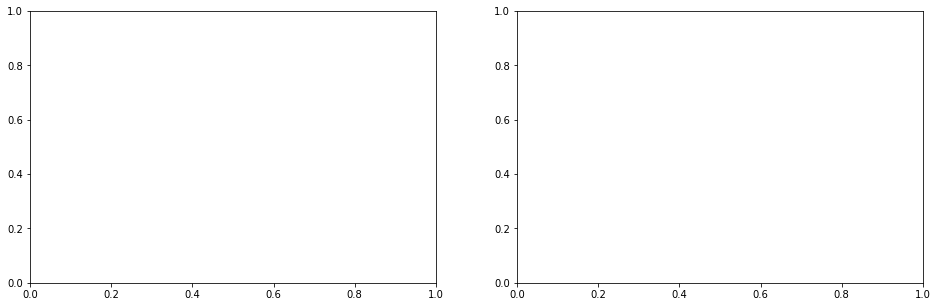

In [16]:
fig, (ax_e, ax_l) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

ax_e.plot(np.arange(len(e0_2d)), e0_2d, linewidth=1)
ax_e.axhline(y=2*np.pi**2, linestyle='-', color='black', linewidth=1)

ax_e.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_e.set_xlabel('Iteration')
ax_e.set_ylabel(r'$\lambda_0$')

ax_e.set_xlim(np.arange(len(e0_2d))[[0,-1]])
# ax_e.set_ylim(9,10)

ax_l.plot(np.arange(len(l0_2d)), l0_2d, linewidth=1)

ax_l.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_l.set_xlabel('Iteration')
ax_l.set_ylabel(r'Loss function')

ax_l.set_xlim(np.arange(len(e0_2d))[[0,-1]])
# ax_l.set_ylim(9.6,10)

fig.savefig('lambda0_loss0_2d.png', dpi=300, bbox_inches='tight')

In [14]:
N = 3  # size of the input vector
perceptron0_3d = Perceptron(N, 1, [100,100]).to(device)

In [15]:
e0_3d, l0_3d = train_loop_laplacian_state0(N, 15000, 100, perceptron0_3d)

Iteration number   E   abs_err_E   Loss
 1000 2.82E+01 1.83E+01 1.00E-05
 2000 2.99E+01 2.00E+01 1.06E-05
 3000 3.15E+01 2.17E+01 1.00E-05
 4000 3.08E+01 2.10E+01 1.00E-05
 5000 3.11E+01 2.12E+01 1.00E-05
 6000 3.06E+01 2.07E+01 1.00E-05
 7000 3.13E+01 2.14E+01 1.00E-05
 8000 3.18E+01 2.20E+01 1.00E-05
 9000 3.18E+01 2.19E+01 1.04E-05
10000 3.18E+01 2.19E+01 1.00E-05
11000 3.16E+01 2.18E+01 1.00E-05
12000 3.20E+01 2.21E+01 1.00E-05
13000 3.17E+01 2.18E+01 1.00E-05
14000 3.16E+01 2.17E+01 1.00E-05
15000 3.18E+01 2.19E+01 1.00E-05


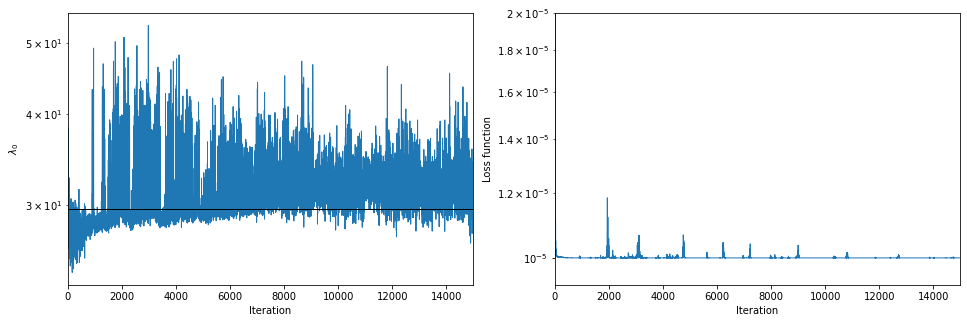

In [16]:
fig, (ax_e, ax_l) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

ax_e.plot(np.arange(len(e0_3d)), e0_3d, linewidth=1)
ax_e.axhline(y=3*np.pi**2, linestyle='-', color='black', linewidth=1)

ax_e.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_e.set_xlabel('Iteration')
ax_e.set_ylabel(r'$\lambda_0$')

ax_e.set_xlim(np.arange(len(e0_3d))[[0,-1]])
# ax_e.set_ylim(9,10)

ax_l.plot(np.arange(len(l0_3d)), l0_3d, linewidth=1)

ax_l.set_yscale('log')
# plt.title(r'$\lambda_0$')
ax_l.set_xlabel('Iteration')
ax_l.set_ylabel(r'Loss function')

ax_l.set_xlim(np.arange(len(e0_3d))[[0,-1]])
ax_l.set_ylim(None, 2e-5)

fig.savefig('lambda0_loss0_3d.png', dpi=300, bbox_inches='tight')

In [20]:
e0_3d.mean() / (3*np.pi**2) -1

0.05275650548829547